In [1]:
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re

In [2]:
df_list = []
file_pattern = "20*.csv"

#lets us go thru all the reg season files w/o having to manually make a list
file_list = glob.glob(file_pattern)
filtered_file_list = [file for file in file_list if not re.search(r'_\w+', os.path.basename(file))]

for file in filtered_file_list:
    year = os.path.basename(file).split('.')[0]

    curr = pd.read_csv(file, header=1)
    
    curr["Year"] = year

    #some rows + columns weren't relevant
    curr = curr.dropna(axis=1, how='all')
    curr = curr.dropna(subset=['Rk'])

    df_list.append(curr)

combined_df = pd.concat(df_list, ignore_index=True).sort_values(by = "Year", ascending = False)
combined_df.head(5)

,Rk,Team,Age,W,L,PW,PL,MOV,SOS,SRS,...,ORB%,off_FT/FGA,eFG%,TOV%,DRB%,FT/FGA,Arena,Attend.,Attend./G,Year
181,2.0,Oklahoma City Thunder*,23.4,57.0,25.0,58,24,7.41,-0.05,7.36,...,21.1,0.198,0.530,13.6,73.8,0.202,Paycom Center,715509.0,17451.0,2024
196,17.0,Sacramento Kings,26.4,46.0,36.0,45,37,1.74,0.55,2.29,...,24.5,0.171,0.555,12.5,78.4,0.213,Golden 1 Center,735015.0,17927.0,2024
180,1.0,Boston Celtics*,28.2,64.0,18.0,66,16,11.34,-0.60,10.75,...,24.9,0.180,0.523,10.8,76.3,0.145,TD Garden,785396.0,19156.0,2024
208,29.0,Portland Trail Blazers,24.1,21.0,61.0,20,62,-9.02,0.74,-8.29,...,27.5,0.181,0.558,12.8,74.0,0.216,Moda Center,751395.0,18327.0,2024
207,28.0,Washington Wizards,24.9,15.0,67.0,20,62,-9.29,0.00,-9.29,...,20.0,0.169,0.562,12.0,72.5,0.201,Capital One Arena,692851.0,16899.0,2024


We also want to add a column to tell us if a team won that year's championship; we can do this manually. For that column, 1s correspond to winning a championship and 0s correspond to not winning a championship.

In [3]:
champions = {'2024': 'Boston Celtics*',
 '2023': 'Denver Nuggets*',
 '2022': 'Golden State Warriors*',
 '2021': 'Milwaukee Bucks*',
 '2020': 'Los Angeles Lakers*',
 '2019': 'Toronto Raptors*',
 '2018': 'Golden State Warriors*',
 '2017': 'Golden State Warriors*',
 '2016': "Cleveland Cavaliers*",
 '2015': 'Golden State Warriors*'}

combined_df['Team'] = combined_df['Team'].str.strip()
combined_df['Won Championship'] = combined_df.apply(lambda row: 1 if champions.get(row['Year']) == row['Team'] else 0, axis = 1)

winners = combined_df[combined_df['Won Championship'] == 1]
winners.head(5)

,Rk,Team,Age,W,L,PW,PL,MOV,SOS,SRS,...,off_FT/FGA,eFG%,TOV%,DRB%,FT/FGA,Arena,Attend.,Attend./G,Year,Won Championship
180,1.0,Boston Celtics*,28.2,64.0,18.0,66,16,11.34,-0.60,10.75,...,0.180,0.523,10.8,76.3,0.145,TD Garden,785396.0,19156.0,2024,1
65,6.0,Denver Nuggets*,26.6,53.0,29.0,49,33,3.33,-0.29,3.04,...,0.194,0.543,12.2,76.4,0.201,Ball Arena,788635.0,19235.0,2023,1
94,5.0,Golden State Warriors*,27.6,53.0,29.0,55,27,5.54,-0.02,5.52,...,0.181,0.509,13.0,78.7,0.201,Chase Center,740624.0,18064.0,2022,1
33,4.0,Milwaukee Bucks*,28.1,46.0,26.0,48,24,5.89,-0.32,5.57,...,0.177,0.536,11.5,79.7,0.157,Fiserv Forum,64780.0,1799.0,2021,1
4,5.0,Los Angeles Lakers*,29.5,52.0,19.0,48,23,5.79,0.49,6.28,...,0.201,0.515,14.1,78.8,0.205,STAPLES Center,588907.0,18997.0,2020,1


Now we can compare teams that won the championship with teams that didn't. However, before we do so, we want to take into account the fact that many defensive metrics have varied over the years. Below are graphs showing how these defensive metrics have evolved over time.

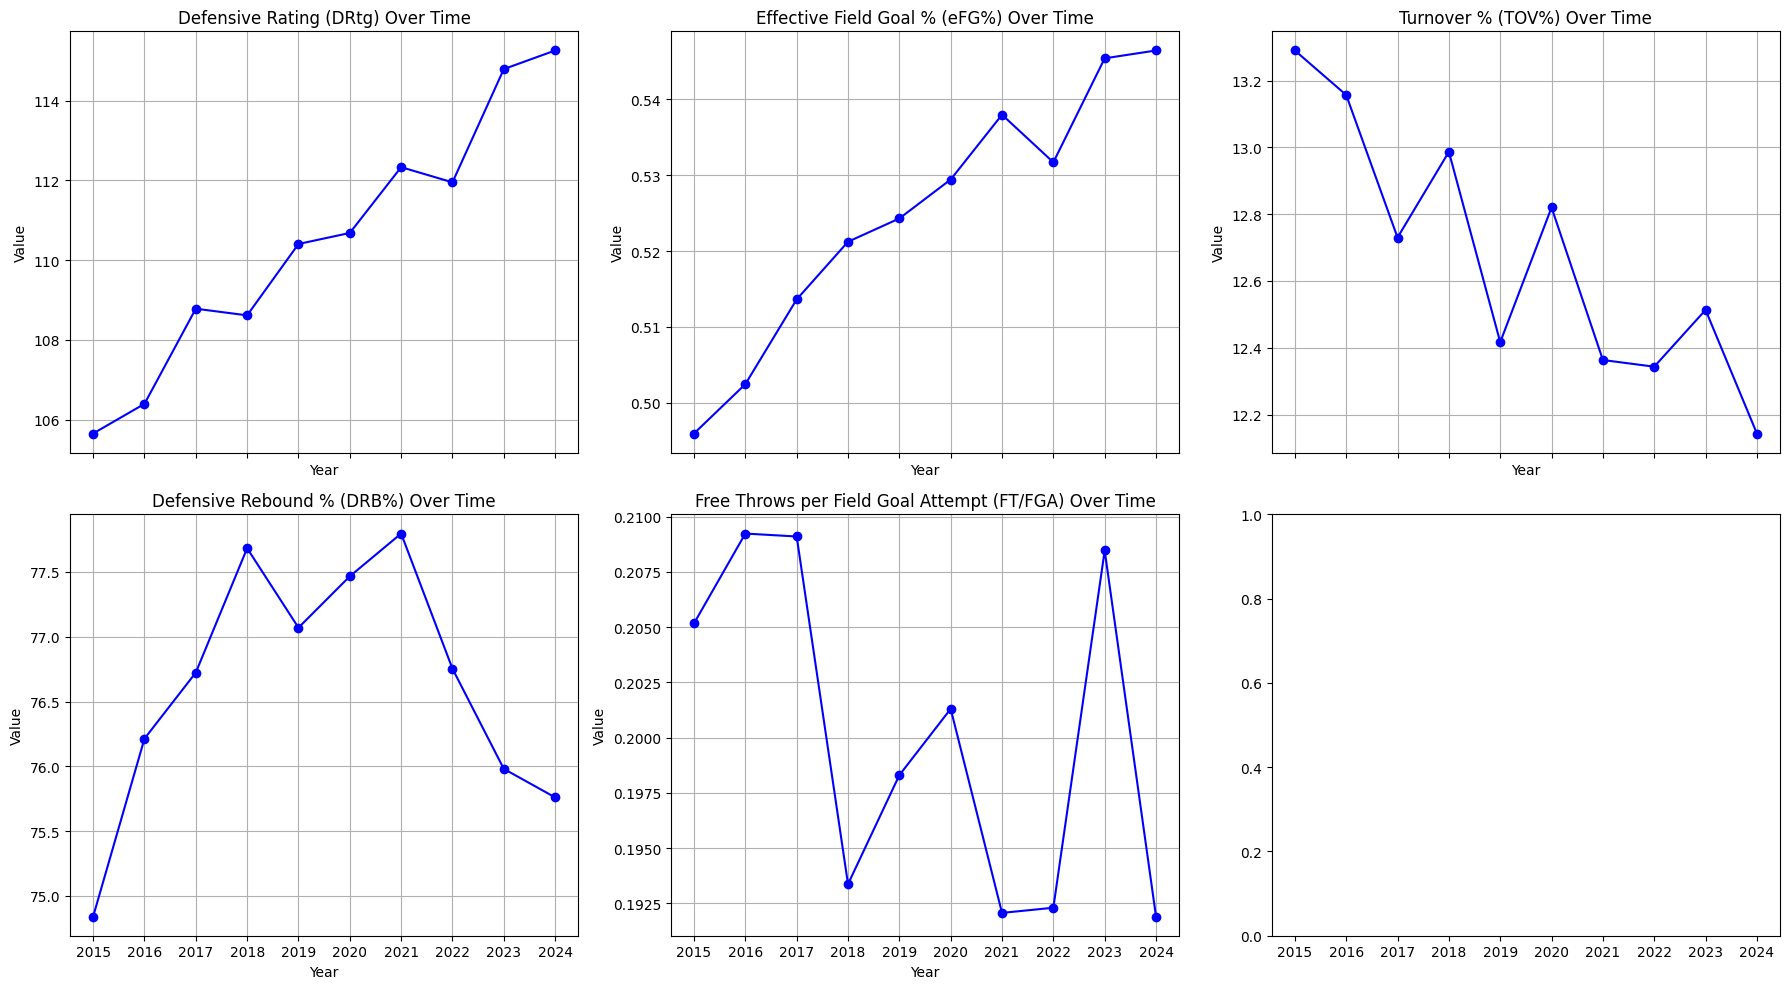

In [4]:
defensive_year_df = combined_df[["Year", "eFG%", "TOV%", "DRB%", "FT/FGA", "DRtg", "Won Championship", "Rk"]]

average_stats_per_year = defensive_year_df.groupby("Year").mean().reset_index()


fig, axes = plt.subplots(2, 3, figsize=(18, 10), sharex=True)

# Flatten the axes array for easy iteration
axes = axes.flatten()

# List of statistics and their labels
stats = ['DRtg', 'eFG%', 'TOV%', 'DRB%', 'FT/FGA']
labels = ['Defensive Rating (DRtg)', 'Effective Field Goal % (eFG%)', 'Turnover % (TOV%)', 'Defensive Rebound % (DRB%)', 'Free Throws per Field Goal Attempt (FT/FGA)']

for i, (stat, label) in enumerate(zip(stats, labels)):
    axes[i].plot(average_stats_per_year["Year"], average_stats_per_year[stat], marker='o', linestyle='-', color='b')
    axes[i].set_title(label + " Over Time")
    axes[i].set_xlabel('Year')
    axes[i].set_ylabel('Value')
    axes[i].grid(True)

plt.tight_layout()

# Display the plot
plt.show()


In order to account for this, we can take the z-score of the relevant columns instead of the raw data

In [5]:
grouped = defensive_year_df.groupby("Year")

defensive_zscore_df = defensive_year_df.copy()

columns_to_zscore = ["eFG%", "TOV%", "DRB%", "FT/FGA", "DRtg"]

for col in columns_to_zscore:
    mean = grouped[col].transform('mean')
    std = grouped[col].transform('std')
    defensive_zscore_df[col] = (defensive_year_df[col] - mean) / std

defensive_zscore_df["Won Championship"] = defensive_year_df["Won Championship"]

defensive_zscore_df = defensive_zscore_df.drop(columns=["Year"])

Now that we have our dataset prepared, we can examine the correlation between these regular season defensive metrics and winning the championship. Below is a bar chart showing the correlation coefficient between these statistics and winning the championship. As you can see, none of the coefficients are particularly significant for predicting championship success.

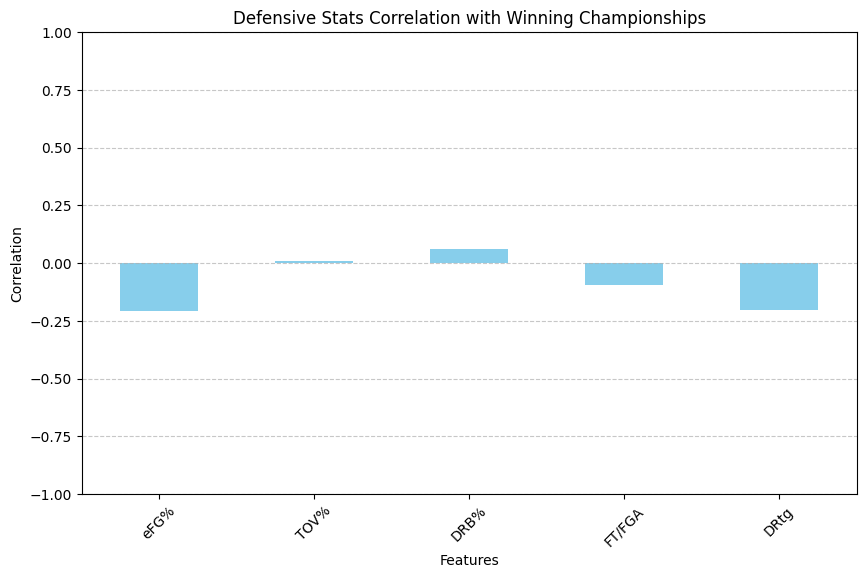

In [13]:
defensive_zscore_df["Rk"] = defensive_year_df["Rk"]
correlations = defensive_zscore_df.corr()
champ_correlations = correlations['Won Championship'].drop("Won Championship").drop("Rk")


plt.figure(figsize=(10, 6))
champ_correlations.plot(kind='bar', color='skyblue')
plt.title('Defensive Stats Correlation with Winning Championships')
plt.xlabel('Features')
plt.ylabel('Correlation')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.ylim(-1,1)
plt.show()

Examining the correlation with regular season rank, however, produces a much more significant result. Note that the positivity of many of the correlation coefficients has been flipped; a higher rank row value is worse.

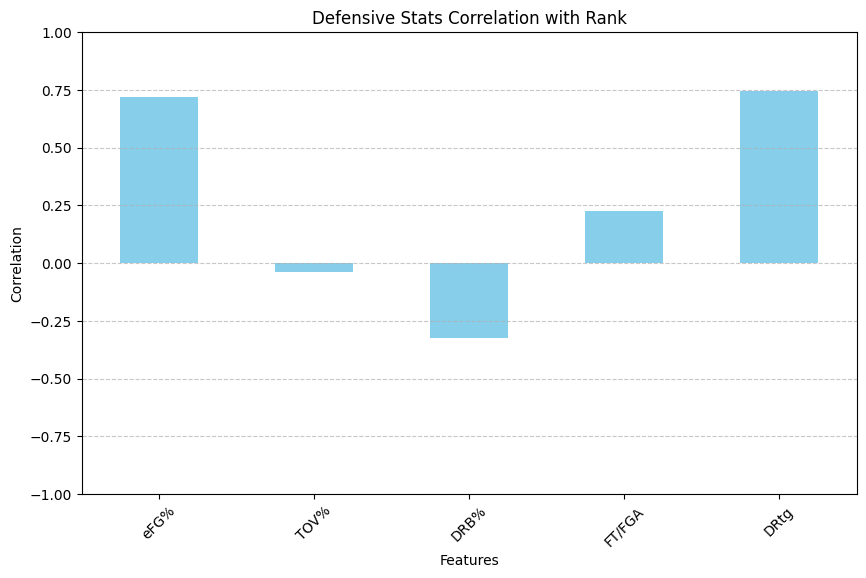

In [15]:
correlations = defensive_zscore_df.corr()
rk_correlations = correlations['Rk'].drop("Rk").drop("Won Championship")


plt.figure(figsize=(10, 6))
rk_correlations.plot(kind='bar', color='skyblue')
plt.title('Defensive Stats Correlation with Rank')
plt.xlabel('Features')
plt.ylabel('Correlation')
plt.xticks(rotation=45)
plt.ylim(-1,1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

We can also graph our data on a scatter plot to get a good look at how our dataset is distributed.

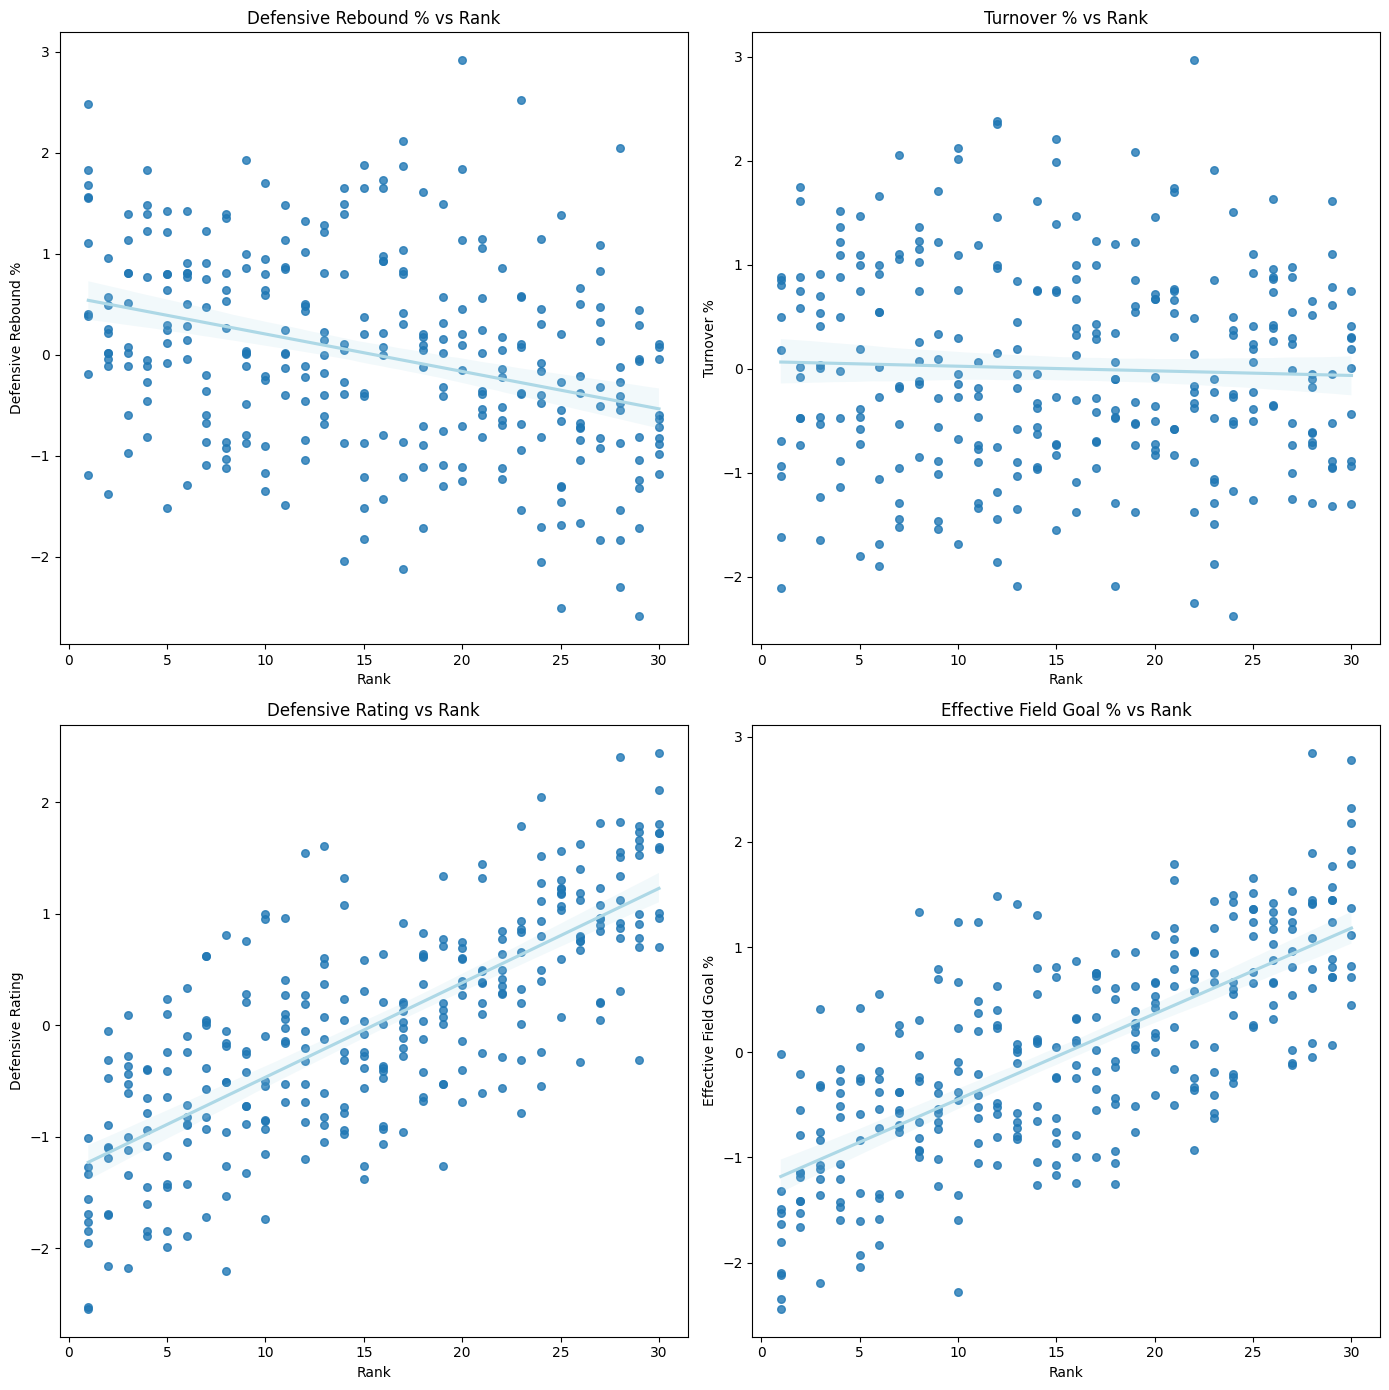

In [16]:
df = defensive_zscore_df
fig, axes = plt.subplots(2, 2, figsize=(14, 14))

sns.regplot(x='Rk', y='DRB%', data=df, ax=axes[0, 0], scatter_kws={"s": 30}, line_kws={"color": "lightblue"})
axes[0, 0].set_title('Defensive Rebound % vs Rank')
axes[0, 0].set_xlabel('Rank')
axes[0, 0].set_ylabel('Defensive Rebound %')

sns.regplot(x='Rk', y='TOV%', data=df, ax=axes[0, 1], scatter_kws={"s": 30}, line_kws={"color": "lightblue"})
axes[0, 1].set_title('Turnover % vs Rank')
axes[0, 1].set_xlabel('Rank')
axes[0, 1].set_ylabel('Turnover %')

sns.regplot(x='Rk', y='DRtg', data=df, ax=axes[1, 0], scatter_kws={"s": 30}, line_kws={"color": "lightblue"})
axes[1, 0].set_title('Defensive Rating vs Rank')
axes[1, 0].set_xlabel('Rank')
axes[1, 0].set_ylabel('Defensive Rating')

sns.regplot(x='Rk', y='eFG%', data=df, ax=axes[1, 1], scatter_kws={"s": 30}, line_kws={"color": "lightblue"})
axes[1, 1].set_title('Effective Field Goal % vs Rank')
axes[1, 1].set_xlabel('Rank')
axes[1, 1].set_ylabel('Effective Field Goal %')

plt.tight_layout()
plt.show()

It seems like defensive rating and effective field goal % are relatively good predictors of regular season success, but defensive rebound % and opposition turnover % are not good indicators of regular season success.

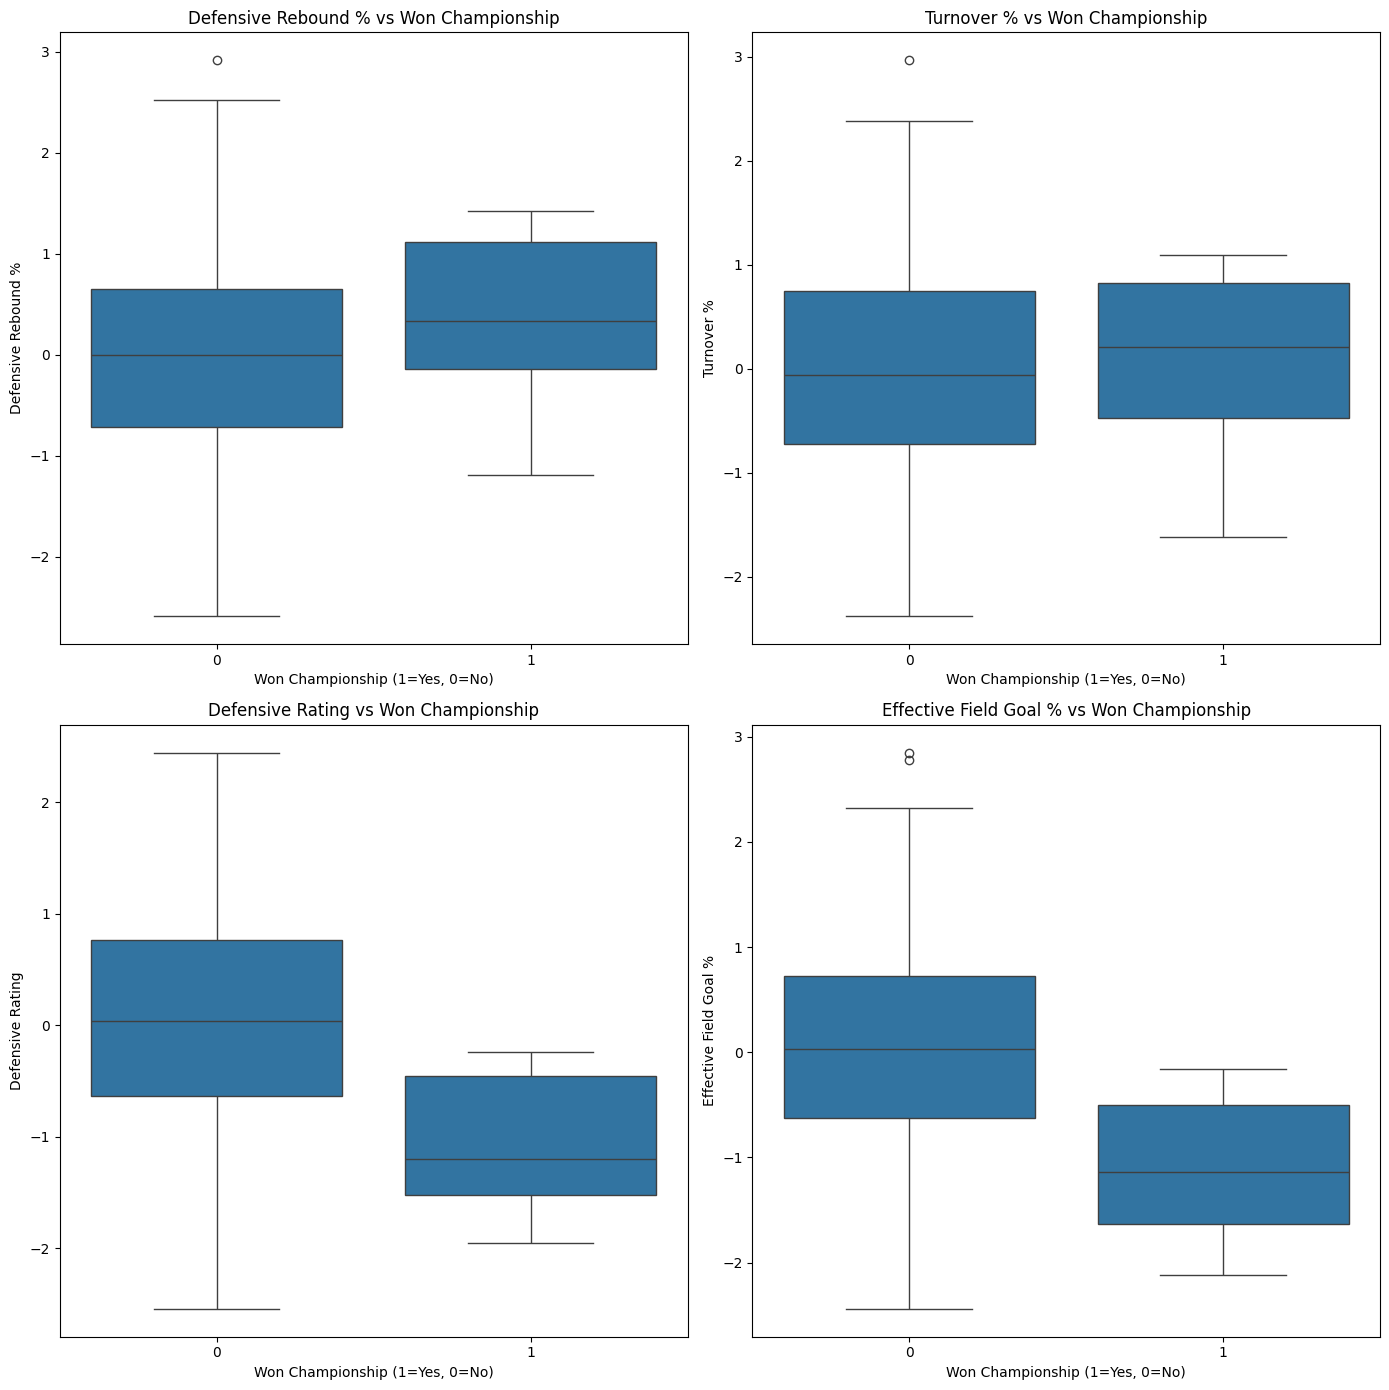

In [10]:
df = defensive_zscore_df
fig, axes = plt.subplots(2, 2, figsize=(14, 14))

sns.boxplot(x='Won Championship', y='DRB%', data=df, ax=axes[0, 0])
axes[0, 0].set_title('Defensive Rebound % vs Won Championship')
axes[0, 0].set_xlabel('Won Championship (1=Yes, 0=No)')
axes[0, 0].set_ylabel('Defensive Rebound %')

sns.boxplot(x='Won Championship', y='TOV%', data=df, ax=axes[0, 1])
axes[0, 1].set_title('Turnover % vs Won Championship')
axes[0, 1].set_xlabel('Won Championship (1=Yes, 0=No)')
axes[0, 1].set_ylabel('Turnover %')

sns.boxplot(x='Won Championship', y='DRtg', data=df, ax=axes[1, 0])
axes[1, 0].set_title('Defensive Rating vs Won Championship')
axes[1, 0].set_xlabel('Won Championship (1=Yes, 0=No)')
axes[1, 0].set_ylabel('Defensive Rating')

sns.boxplot(x='Won Championship', y='eFG%', data=df, ax=axes[1, 1])
axes[1, 1].set_title('Effective Field Goal % vs Won Championship')
axes[1, 1].set_xlabel('Won Championship (1=Yes, 0=No)')
axes[1, 1].set_ylabel('Effective Field Goal %')

plt.tight_layout()
plt.show()
